In [444]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

## Load data, split and normalise

In [422]:
path = Path.cwd()/'data'/'gasoline.csv'
data = pd.read_csv(path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
oil_price = data[['OT']]
oil_price.columns = ['price']
oil_price = oil_price.loc["2003-01-01":]
print(oil_price.shape)

(1113, 1)


In [424]:
tr_size = int(oil_price.shape[0]*0.5)
test_size = oil_price.shape[0] - tr_size
train, test = oil_price[:tr_size], oil_price[tr_size:]
print(train.shape)
print(test.shape)

(556, 1)
(557, 1)


In [426]:
scaler = StandardScaler()
scaler.fit(train)


StandardScaler()

## Dataset for time series

In [429]:
class CustomDataset(Dataset):
    def __init__(self, data, lag=7):
        """
        Args:
            data(np.ndarray): dim is (N , 1)
            lag(int): context or window length
        """
        self.X = list()
        self.y = list()
        for i in range(len(data) - lag):
            x = data[i : i + lag]
            y = data[i + lag]
            self.X.append(x.flatten())
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]      

In [431]:
train_scaled = scaler.transform(train)
len(train_scaled)

556

In [433]:
test_scaled = scaler.transform(test)
len(test_scaled)

557

## Model Building

In [435]:
class LSTMModel(nn.Module):
    def __init__(self, in_size, hid_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hid_size,
            batch_first=True,
            proj_size=1,
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        return x

In [437]:
def train_model(
    model,
    optimiser,
    loss_fn,
    epochs,
    batch,
    data,
    lag
):
    dataset = CustomDataset(data, lag)
    loader = DataLoader(dataset, batch_size=batch)
    tr_losses = list()
    val_losses = list()

    for i in range(epochs):
        train_loss = list()
        val_loss = list()
        for j, (X, y) in enumerate(loader):
            n = X.shape[0]
            tr_size = int(n*0.9)
            X_train, y_train = X[:tr_size, :], y[:tr_size, :]
            X_val, y_val = X[tr_size:, :], y[tr_size:, :]

            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            train_loss.append(loss.item())
            # if (j+1)%3 == 0:
            #     print(f"Epoch - {i+1}, step - {j+1}, train_loss = {loss.item()}")
            with torch.no_grad():
                y_pred_val = model(X_val)
                val_loss.append(loss_fn(y_pred_val, y_val).item())
        tr_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
    plt.plot(tr_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.title(f"Window Size = {lag}")
    plt.show()


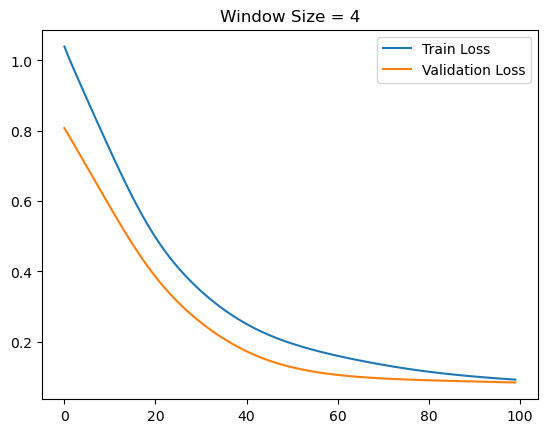

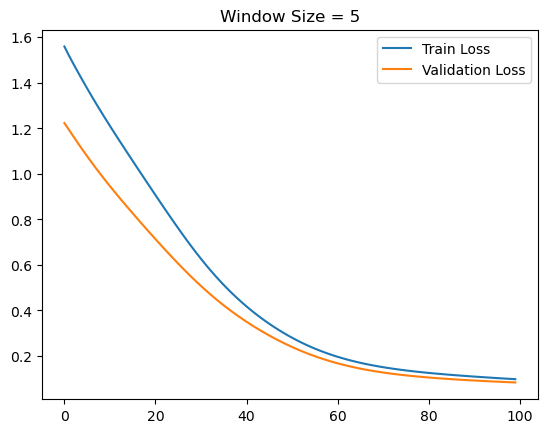

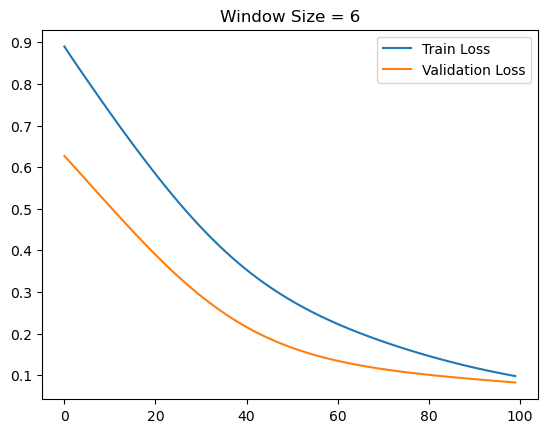

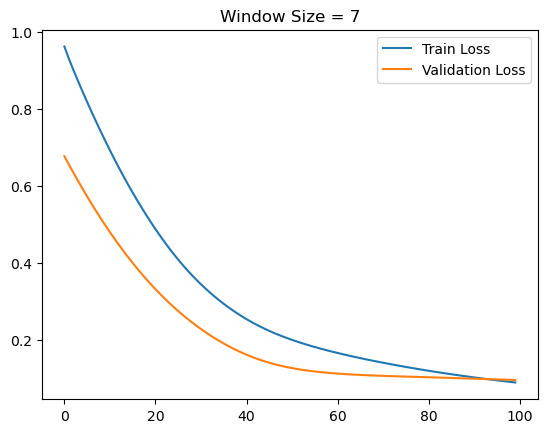

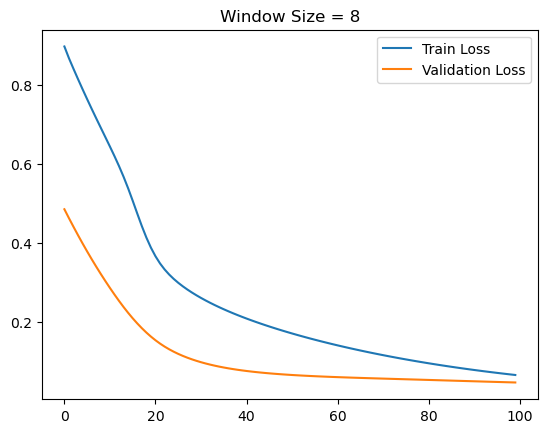

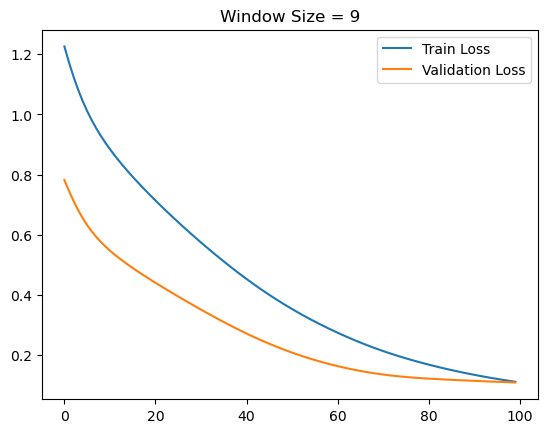

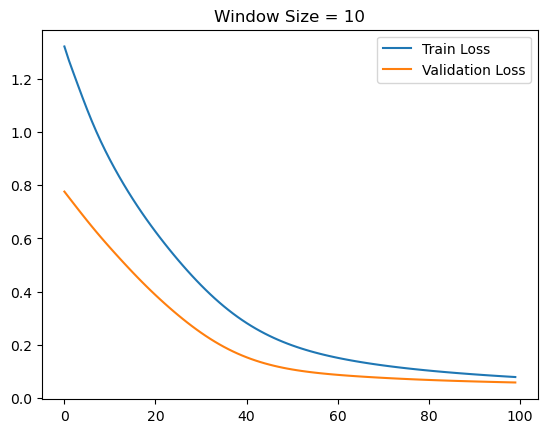

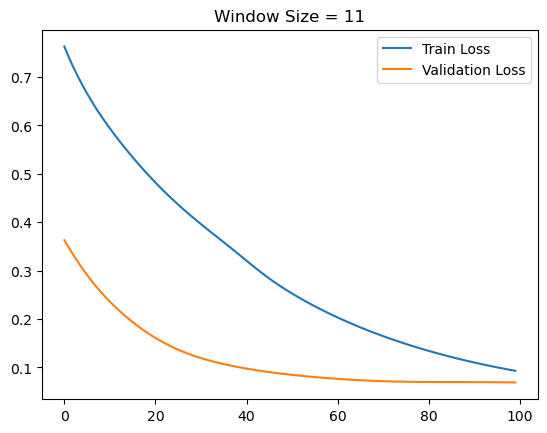

In [439]:
batch = 128
epochs = 100
lags = list(range(4,12))
for lag in lags:
    model = LSTMModel(in_size=lag, hid_size=5)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_model(model, optimiser, loss_fn, epochs, batch, train_scaled, lag)

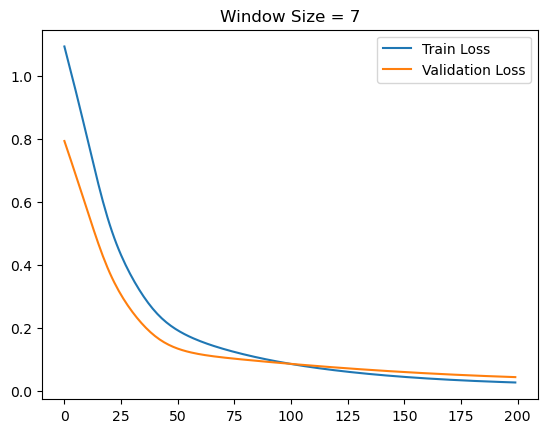

In [441]:
batch = 128
epochs = 200
lag = 7
model = LSTMModel(in_size=lag, hid_size=5)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train_model(model, optimiser, loss_fn, epochs, batch, train_scaled, lag)

## Test Performance (Weekly Forecast) - model trained for context length  = 7

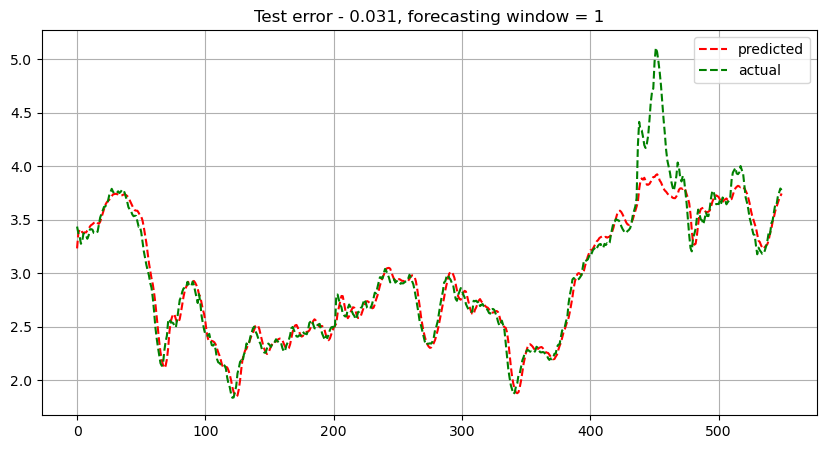

In [565]:
testloader = DataLoader(CustomDataset(test_scaled, lag=7), batch_size=len(test_scaled))
for X, y in testloader:
    y_pred = model(X)
    y = y.detach().numpy()
    y_pred = y_pred.detach().numpy()
    y = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)
    plt.figure(figsize=(10,5))
    plt.plot(y_pred, 'r--', label='predicted' )
    plt.plot(y, 'g--', label='actual')
    plt.legend()
    test_error = mean_squared_error(y_pred, y)
    plt.grid()
    plt.title(f"Test error - {test_error:0.3f}, forecasting window = 1")

## Test Performance (3 Week Forecast) - model trained for context length  = 7

In [506]:
class ModelInference:
    def __init__(self, model):
        self.model = model

    def predict(self, x, window=1):
        """
        Args:
            x (torch.tensor or np.ndarray): dimension (1, window_length) or (window_length, )
        Returns:
            y_pred(np.ndarray): dimension (1, window)
        """
        inp = (x.flatten()).tolist()
        pred = list()
        for _ in range(window):
            x = torch.tensor(np.array(inp), dtype=torch.float32)
            x = torch.unsqueeze(x, 0)
            y_pred = model(x)[0,0]
            y_pred = y_pred.item()
            pred.append(y_pred)
            inp.pop(0)
            inp.append(y_pred)
        pred = np.array(pred)
        return pred

In [511]:
inference = ModelInference(model)

In [513]:
testdataset = CustomDataset(test_scaled, lag=7)

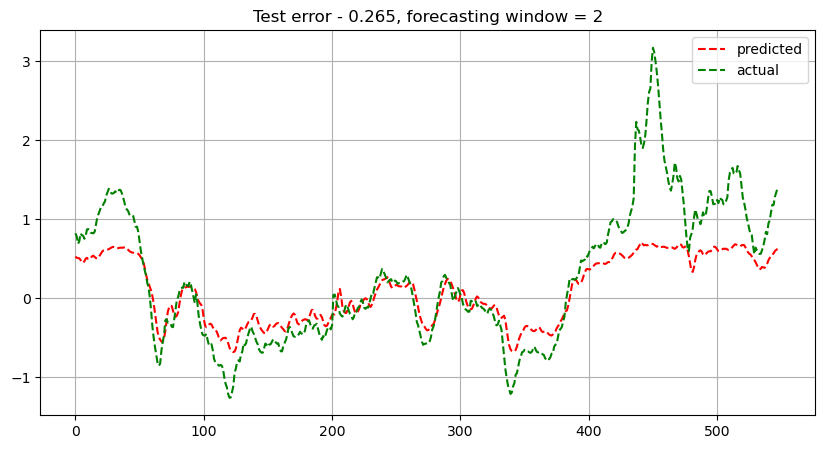

In [563]:
window = 2
actual = list()
predicted = list()
for x, y in testdataset:
    y_pred = inference.predict(x, window)[-1]
    actual.append(y)
    predicted.append(y_pred)
actual = actual[window-1:]
actual = np.array(actual)
predicted = np.array(predicted)
plt.figure(figsize=(10,5))
plt.plot(predicted, 'r--', label='predicted' )
plt.plot(actual, 'g--', label='actual')
plt.legend()
test_error = mean_squared_error(actual, predicted[0:-window+1])
plt.title(f"Test error - {test_error:0.3f}, forecasting window = {window}")
plt.grid()
plt.show()